In [2]:
from collections import Counter
import os
import json
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [3]:
from liked2play.utils import get_access_token

ModuleNotFoundError: No module named 'liked2play'

In [4]:
GDPR_DATA_FOLDER = "../data/raw/MyData/"
client_id_path = "../secrets/client_id.txt"
client_secret_path = "../secrets/client_secret.txt"

In [5]:
os.listdir(GDPR_DATA_FOLDER)

['Follow.json',
 'Inferences.json',
 'Userdata.json',
 'SearchQueries.json',
 'Playlist1.json',
 'StreamingHistory0.json',
 'YourLibrary.json',
 'Payments.json',
 'StreamingHistory1.json',
 'Read_Me_First.pdf',
 'Identifiers.json']

- `Follow.json`: contains follower and following count as well as artists I am following `followingArtists`
- `Inferences.json`: contains some inferences on device usage and my personality as well as interests
- `Userdata.json`: demographic and registration data
- `SearchQueries.json`: contains the query terms, UTC timestamps, device and correponding element interacted with in the results (track, playlist, none, artist)
- `Playlist1.json`: contains self-created playlists or those which I copied there as one

Key Data:

- `YourLibrary.json`: contains music albums I hav in my library as well as Podcast shows and episodes, in particular `tracks` which seems to resemble the "Liked Songs" judging on the number of tracks that is in line with the number I see in my app. Ea. track is a dictionary that contains `artist`, `album`, `track`, and `uri` (name)
    - put into a pandas DataFrame
    - count the artists
    - search for duplicates
    - count the albums
- `StreamingHistoryX.json`: could be multiple ones, X stands for continuing number starting with 0, ea. seems to be capped by 10000 items, sorted by time of consumption
    - load an join all of them, put into a DataFrame
    - check the distribution of listening length (one would also need the length of ea. track here)
    - filter for items beyond e.g. 30 seconds

In [6]:
play_threshold = 30*1000

## Streaming History

In [7]:
streamed_songs = list()

for filename in os.listdir(GDPR_DATA_FOLDER):
    if filename.startswith("StreamingHistory"):
        with open(os.path.join(GDPR_DATA_FOLDER, filename)) as file:
            streamed_songs.extend(json.load(file))
            
streamed_songs = pd.DataFrame(streamed_songs)
streamed_songs.shape

(15545, 4)

In [10]:
streamed_songs["endTime"].min()

'2020-12-04 21:38'

In [11]:
streamed_songs["endTime"].max()

'2021-12-05 22:30'

In [10]:
# remove streams that have been skipped due to mostly dislike, i.e. those for which the streaming time is below `play_threshold`
before = streamed_songs.shape[0]
streamed_songs = streamed_songs[streamed_songs["msPlayed"] >= play_threshold]

In [11]:
skipped_songs_ratio = 1 - streamed_songs.shape[0] / before
skipped_songs_ratio

0.14474107430041816

In [12]:
streamed_songs["msPlayed"]

1        172907
2        253747
4        107867
5        208080
6        351627
          ...  
15540    156258
15541     91950
15542    125100
15543    149160
15544    112127
Name: msPlayed, Length: 13295, dtype: int64

In [13]:
song_stream_durations = streamed_songs["msPlayed"]/1000

In [14]:
song_stream_durations.describe()

count    13295.000000
mean       226.269244
std        104.427253
min         30.005000
25%        176.186000
50%        218.867000
75%        260.799500
max       3281.031000
Name: msPlayed, dtype: float64

In [15]:
max_dur = song_stream_durations.quantile(0.98)

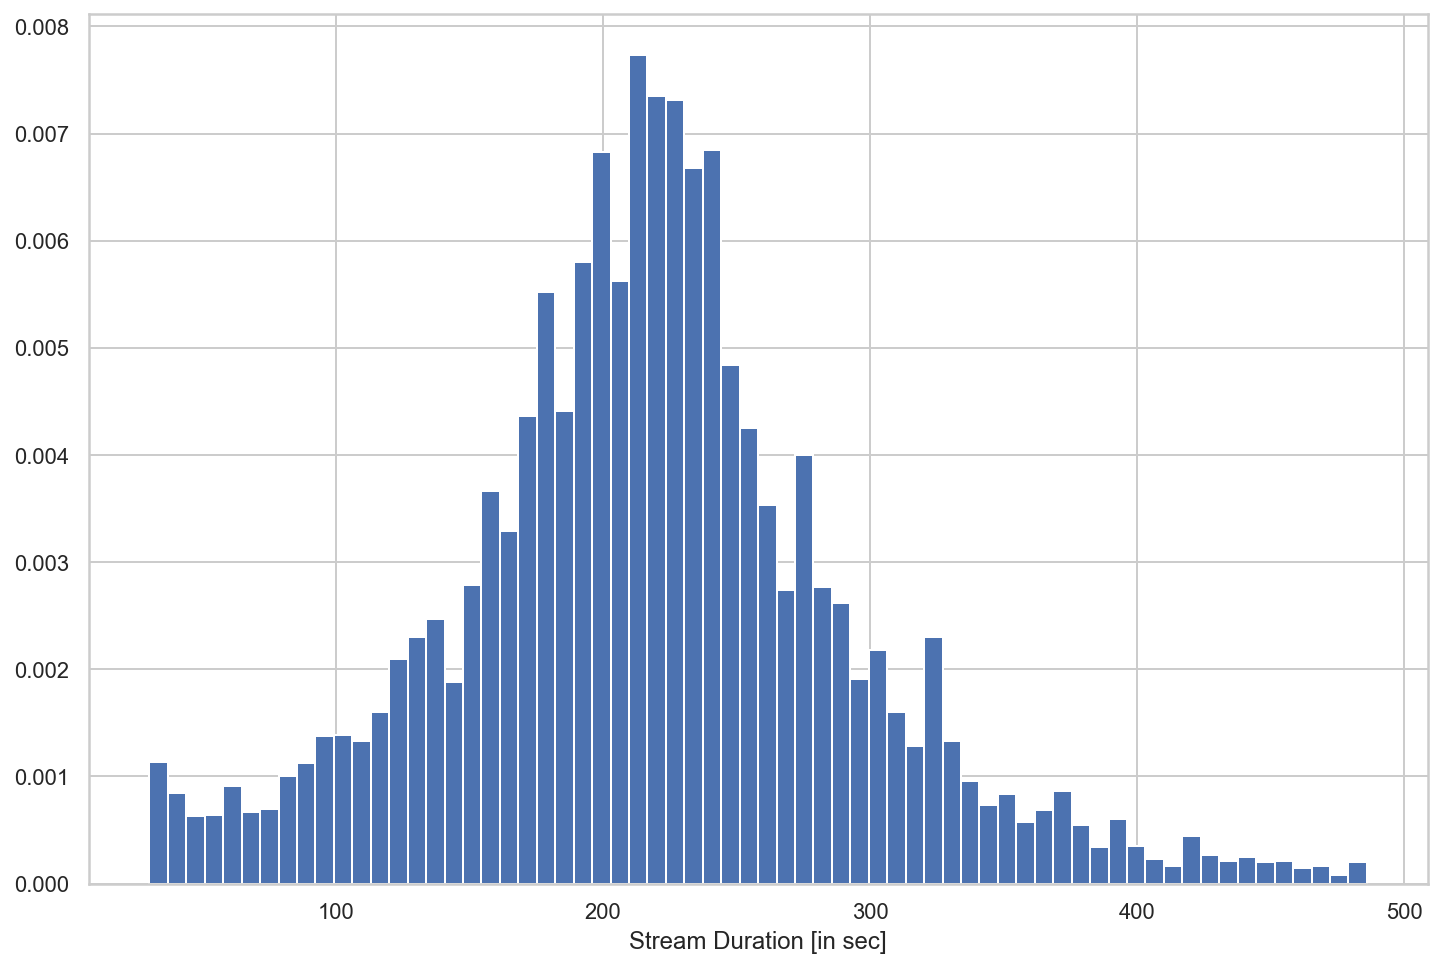

In [16]:
plt.figure(figsize=(12,8))
plt.hist(song_stream_durations[song_stream_durations <= max_dur], bins="auto", density=True)
plt.grid(True)
plt.xlabel("Stream Duration [in sec]")
plt.show()

In [17]:
streamed_songs.shape

(13295, 4)

In [20]:
streamed_songs["artistName"].value_counts().iloc[:10].to_dict()

{'Tim Bendzko': 534,
 'Daft Punk': 533,
 'Neil Young': 275,
 'The Killers': 156,
 'Bläck Fööss': 124,
 'Die Toten Hosen': 123,
 'Modern Talking': 122,
 'Northern Lite': 113,
 'Dotan': 113,
 'Get Well Soon': 109}

In [29]:
counter = Counter([a + ": " + b for a, b in zip(streamed_songs["artistName"].values,
                                                streamed_songs["trackName"].values)])
play_counts = pd.DataFrame(counter.most_common(), columns=["track", "count"])

In [30]:
play_counts.head(20)

,track,count
0,Get Well Soon: Funny Treats,104
1,Northern Lite: I See a Darkness,93
2,Tim Bendzko: Keine Maschine,65
3,Bastille: Icarus,52
4,Tim Bendzko: Hoch,48
5,Graeme Cornies: The War Still Rages Within,46
6,Die Ärzte: Deine Schuld,44
7,Chris de Burgh: Don't Pay The Ferryman,44
8,Bläck Fööss: Kaffeebud,40
9,Harry Gregson-Williams: Metal Gear Solid: Sons...,36


In [29]:
# information about most recent play
most_recently_played = (
    streamed_songs
    .sort_values("endTime", ascending=False)
    .drop_duplicates(subset=["artistName", "trackName"], keep="first")
)
most_recently_played["date"] = pd.to_datetime(most_recently_played["endTime"]).dt.strftime("%Y-%m-%d")
most_recently_played["artist_track"] = [a + ": " + b for a, b in zip(most_recently_played["artistName"].values,
                                                                     most_recently_played["trackName"].values)]
most_recently_played = most_recently_played[["date", "artist_track"]]

## Liked Songs and Liked Albums

In [21]:
with open(os.path.join(GDPR_DATA_FOLDER, "YourLibrary.json")) as file:
    liked_songs = json.load(file)["tracks"]
    liked_songs = pd.DataFrame(liked_songs)
    
with open(os.path.join(GDPR_DATA_FOLDER, "YourLibrary.json")) as file:
    liked_albums = json.load(file)["albums"]
    liked_albums = pd.DataFrame(liked_albums)

In [22]:
liked_songs["artist"].value_counts()

Coldplay               47
Querbeat               43
Muse                   41
Jeff Beal              38
Woodkid                38
                       ..
Marcus Wiebusch         1
Racing Glaciers         1
Pan-Pot                 1
Yusuf / Cat Stevens     1
Seewolf                 1
Name: artist, Length: 900, dtype: int64

In [23]:
liked_songs["album"].value_counts()

Randale & Hurra                            39
House of Cards, Season 2                   35
Spectre                                    26
TRON: Legacy                               22
Das letzte Konzert - Zürich 2014 (Live)    21
                                           ..
Every Valley                                1
In the Shadows                              1
Konfetti                                    1
Ahead Of You Forever                        1
Amore                                       1
Name: album, Length: 1266, dtype: int64

In [24]:
liked_songs["id"] = liked_songs["uri"].apply(lambda val: val.split(":")[-1])
liked_songs["artist_track"] = [a + ": " + b for a, b in zip(liked_songs["artist"].values,
                                                            liked_songs["track"].values)]

In [27]:
liked_songs["artist_track"].value_counts().value_counts()

1    1731
2      51
3       4
Name: artist_track, dtype: int64

In [31]:
liked_songs = liked_songs.merge(play_counts, how="left", left_on="artist_track", right_on="track")

In [33]:
liked_songs["count"] = liked_songs["count"].fillna(0)

In [35]:
(liked_songs["count"] == 0).sum()

1115

In [42]:
(liked_songs["count"] != 0).sum()

730

## Fetch Audio Features for Liked Songs

* https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

In [38]:
with open(client_id_path, "r") as file:
    client_id = file.read().strip("\n")
    
with open(client_secret_path, "r") as file:
    client_secret = file.read().strip("\n")

In [39]:
token = get_access_token(client_id, client_secret)
headers = {
    "Authorization": "Bearer " + token
}

In [40]:
base_url = "https://api.spotify.com"
endpoint = "/v1/audio-features"
url = f"{base_url}{endpoint}"

In [41]:
all_ids = liked_songs["id"].values.tolist()

In [29]:
batch_size = 100
sleep_seconds_between_batches = 5

## Join all the Stuff

In [43]:
audio_features = pd.read_csv("../data/interim/audio_features.csv")

In [49]:
liked_songs = liked_songs.merge(play_counts, how="left", left_on="artist_track", right_on="track")
# liked_songs["count"] = liked_songs["count"].fillna(0)  # move up to creation of play_counts
liked_songs = liked_songs.merge(most_recently_played, how="left", on="artist_track")
liked_songs = liked_songs.merge(audio_features.drop(columns="id"), how="left", on="uri")

In [35]:
liked_songs.to_csv("../data/interim/liked_songs_augmented.csv", index=False)

In [36]:
from datetime import datetime

In [39]:
datetime.now().strftime("%Y%m%d_%H%M")

'20211219_1406'

In [50]:
not_listened_ratio = (liked_songs["count"] == 0).sum() / liked_songs["count"].shape[0]
not_listened_ratio

0.0